**AutoRec Project**

# Imports

In [1]:
%matplotlib inline

In [2]:
!pip install keras-tuner

In [3]:
from google.colab import drive
import os

# keras
from tensorflow.keras.models import load_model
import tensorflow as tf
import keras_tuner as kt

# sklearn
from sklearn.model_selection import train_test_split

import sys
import requests
import zipfile
import copy
import shutil

import pandas as pd
import numpy as np
import random
import math

from matplotlib import pyplot as plt

In [4]:
np.random.seed(123)
random.seed(123)

In [5]:
!git clone https://github.com/aviadar/RecSys_AutoRecProject proj

fatal: destination path 'proj' already exists and is not an empty directory.


In [6]:
sys.path.insert(0,'/content/proj/src')

from utilities.Metrics import Metrics
from models.MF import MF
from models.IAutoRec import IAutoRec
from models.IAutoRecEnhanced import IAutoRecEnhanced
from models.IAutoRecEnhanced2 import IAutoRecEnhanced2
# from models.IAutoRecEnhanced2 import IAutoRecEnhanced2 as IAutoRecEnhanced3

# MovieLens 1M Dataset

## Data Loading & Manipulation

In [7]:
url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
zip_name = 'ml-1m.zip'
data_dir = 'ml-1m/'

r = requests.get(url, allow_redirects=True)
open(zip_name, 'wb').write(r.content)

with zipfile.ZipFile(zip_name,"r") as zip_ref:
    zip_ref.extractall()

In [8]:
ratings_df = pd.read_csv('/content/ml-1m/ratings.dat', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], delimiter='::')
ratings_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


we are not intrested in timestamps, so we can remove the column. <br>
also, in order to keep embedding size as small as possible, we need to change the user and item ids.

In [9]:
ratings_df.drop(columns='timestamp', inplace=True)

def user_id_trans(idx):
    return idx-1

item_id_trans_dict =  {k:v for k,v in zip(ratings_df.item_id.unique(),range(ratings_df.item_id.nunique()))}
def item_id_trans(key_value):
    return item_id_trans_dict[key_value]

ratings_df.user_id = ratings_df.user_id.apply(user_id_trans)
ratings_df.item_id = ratings_df.item_id.apply(item_id_trans)

ratings_df.head()

,user_id,item_id,rating
0,0,0,5
1,0,1,3
2,0,2,3
3,0,3,4
4,0,4,5


In [10]:
ml_users_num, ml_items_num = ratings_df.user_id.nunique(), ratings_df.item_id.nunique()
ml_users_num, ml_items_num

(6040, 3706)

## Train\Test Split

splitting the data into train, validation and test:

In [11]:
train, test = train_test_split(ratings_df, test_size=0.1, random_state=999613182)
train.user_id.nunique(), train.item_id.nunique()

def create_full_mat(df):
    full_mat = np.zeros((ml_users_num, ml_items_num))
    for user, item, rating in zip(df.user_id, df.item_id, df.rating):
        full_mat[user, item] = rating
    return full_mat

full_train_mat = create_full_mat(train)
full_test_mat = create_full_mat(test)

In [12]:
def df_to_mat(df):
    full_mat = np.zeros((df.user_id.max()+1, df.item_id.max()+1))
    for user, item, rating in zip(df.user_id, df.item_id, df.rating):
        full_mat[user, item] = rating
    return full_mat

## Matrix Factorization

### Hyperparameter Tuning

creating and fitting the model:

In [13]:
mf = MF(users_num=ratings_df.user_id.max()+1, items_num=ratings_df.item_id.max()+1)

In [14]:
tuner = kt.Hyperband(mf.model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='hyper_params',
                     project_name='mf_ml')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 10)        60400       ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 10)        37060       ['item_input[0][0]']             
                                                                                              

In [15]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search([np.array(train.user_id), np.array(train.item_id)], np.array(train.rating), 
             epochs=10, validation_split=0.2, callbacks=[stop_early], batch_size=512)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 8 Complete [00h 00m 10s]
val_loss: 0.8821643590927124

Best val_loss So Far: 0.8821643590927124
Total elapsed time: 00h 01m 20s
INFO:tensorflow:Oracle triggered exit


In [16]:
best_hps.get('latent_dim'), best_hps.get('learning_rate')

(40, 0.001)

### Retraining

In [17]:
mf_opt = MF(users_num=ratings_df.user_id.max()+1, items_num=ratings_df.item_id.max()+1, latent_dim=best_hps.get('latent_dim'), learning_rate=best_hps.get('learning_rate'))
mf_opt.build_opt_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 40)        241600      ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 40)        148240      ['item_input[0][0]']             
                                                                                            

In [18]:
mf_opt.fit(train.user_id, train.item_id, labels=train.rating)

Epoch 1/100
1583/1583 [==============================] - 5s 3ms/step - loss: 6.0640 - val_loss: 1.0787
Epoch 2/100
1583/1583 [==============================] - 4s 3ms/step - loss: 0.9097 - val_loss: 0.8417
Epoch 3/100
1583/1583 [==============================] - 4s 3ms/step - loss: 0.8148 - val_loss: 0.8085
Epoch 4/100
1583/1583 [==============================] - 4s 3ms/step - loss: 0.7849 - val_loss: 0.7913
Epoch 5/100
1583/1583 [==============================] - 4s 3ms/step - loss: 0.7636 - val_loss: 0.7811
Epoch 6/100
1583/1583 [==============================] - 4s 3ms/step - loss: 0.7436 - val_loss: 0.7695
Epoch 7/100
1583/1583 [==============================] - 4s 3ms/step - loss: 0.7237 - val_loss: 0.7615
Epoch 8/100
1583/1583 [==============================] - 4s 3ms/step - loss: 0.7028 - val_loss: 0.7531
Epoch 9/100
1583/1583 [==============================] - 4s 3ms/step - loss: 0.6816 - val_loss: 0.7468
Epoch 10/100
1583/1583 [==============================] - 4s 3ms/step - l

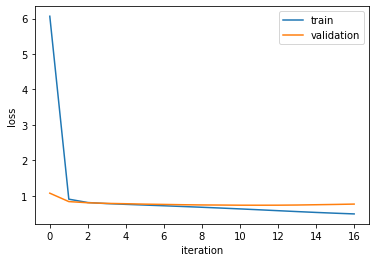

In [19]:
# plot training history
plt.plot(mf_opt.hist.history['loss'], label='train')
plt.plot(mf_opt.hist.history['val_loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.show()

In [20]:
mf_opt.model = load_model('best_mf_model.h5')

In [21]:
shutil.rmtree('/content/hyper_params')

### Prediction

test prediction:

In [22]:
mf_opt.predict(test.user_id, test.item_id)

13/13 [==============================] - 0s 2ms/step


### Evaluation

In [23]:
pred_df = test.copy()
pred_df.rating = mf_opt.predictions.reshape(-1)
pred_mat = df_to_mat(pred_df)
test_mat = df_to_mat(test)

In [24]:
mf_opt_eval = Metrics.get_evaluation(test_mat, pred_mat)
mf_opt_eval

{'MRR_10': 0.9774075317553578,
 'MRR_5': 0.9774075317553578,
 'NDCG_10': 0.967012752521961,
 'NDCG_100': 0.9720530387891683,
 'NDCG_5': 0.9716757049830788,
 'RMSE': 0.8585930189129368}

Text(0, 0.5, 'values')

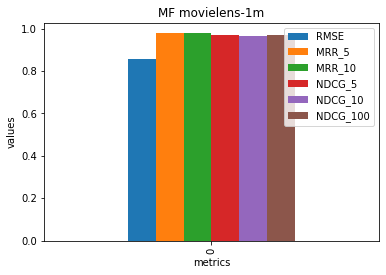

In [25]:
mf_opt_eval_df = pd.DataFrame(mf_opt_eval, index=[0])
mf_opt_eval_df.plot(kind='bar')
plt.title('MF movielens-1m')
plt.xlabel('metrics')
plt.ylabel('values')

Note that we approximately reached the RMSE described in the paper (0.858 vs. 0.845). Furthermore our implementation uses regular MF where as the paper comparison is Biased-MF based.

## AutoRec

### Data Manipulation

In [13]:
def dataPreprocessor(rating_df):
    # train_df, test_df = train_test_split(rating_df, test_size=0.1, random_state=42)
    train_df, test_df = train_test_split(rating_df, test_size=0.1, random_state=999613182)
    train_mat = np.zeros((rating_df.user_id.nunique(), rating_df.item_id.nunique()))
    for (user_id, item_id, rating) in zip(train_df.user_id, train_df.item_id, train_df.rating):
        train_mat[user_id, item_id] = rating

    ## tmp ##
    # train_mat_avg = copy.copy(train_mat)
    # avg = np.true_divide(train_mat_avg.sum(1), np.maximum((train_mat_avg!=0).sum(1), 1))
    # inds = np.where(train_mat_avg == 0)
    # train_mat_avg[inds] = np.take(avg, inds[0])

    test_mat = np.zeros((rating_df.user_id.nunique(), rating_df.item_id.nunique()))
    for (user_id, item_id, rating) in zip(test_df.user_id, test_df.item_id, test_df.rating):
        test_mat[user_id, item_id] = rating
    
    return train_mat, test_mat #, train_mat_avg

### Hyperparameters Tuning

hyperparameters:


*   hidden units = {300, 500, 700, 900}
*   regularization = {0.001, 0.0001}
*   learning rate = {1e-3, 1e-4}
*   in activation function = {RELU, Sigmoid, ELU}
*   out activation function = {RELU, Sigmoid, ELU}


In [27]:
train_mat, test_mat = dataPreprocessor(ratings_df)
autorec = IAutoRec(train_mat.shape[1])
tuner = kt.Hyperband(autorec.model_builder,
                    #  objective='val_loss',
                     objective='loss',
                     max_epochs=500,
                     directory='hyper_params',
                     project_name='autorec_ml')


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 item_rating (InputLayer)    [(None, 3706)]            0         
                                                                 
 latent_dim (Dense)          (None, 300)               1112100   
                                                                 
 item_pred_rating (Dense)    (None, 3706)              1115506   
                                                                 
Total params: 2,227,606
Trainable params: 2,227,606
Non-trainable params: 0
_________________________________________________________________


In [28]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
tuner.search(train_mat, train_mat,
             epochs=500, validation_split=0.1, callbacks=[stop_early], batch_size=512)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 124 Complete [00h 00m 02s]
loss: 3.233260154724121

Best loss So Far: 1.177046537399292
Total elapsed time: 00h 03m 40s
INFO:tensorflow:Oracle triggered exit


In [29]:
best_hps.get('hidden_units'), best_hps.get('first_activation'), best_hps.get('last_activation') ,best_hps.get('reg'), best_hps.get('learning_rate')

(300, 'sigmoid', 'elu', 0.0001, 0.001)

### Retraining

In [30]:
autorec_opt = IAutoRec(train_mat.shape[1],hidden_units=best_hps.get('hidden_units'), reg=best_hps.get('reg'), 
                       learning_rate=best_hps.get('learning_rate'), first_activation=best_hps.get('first_activation'),
                       last_activation=best_hps.get('last_activation'))
autorec_opt.build_opt_model()
autorec_opt.fit(train_mat, train_mat)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 item_rating (InputLayer)    [(None, 3706)]            0         
                                                                 
 latent_dim (Dense)          (None, 300)               1112100   
                                                                 
 item_pred_rating (Dense)    (None, 3706)              1115506   
                                                                 
Total params: 2,227,606
Trainable params: 2,227,606
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
22/22 - 1s - loss: 2.0533 - val_loss: 1.3166 - 631ms/epoch - 29ms/step
Epoch 2/500
22/22 - 0s - loss: 1.1515 - val_loss: 1.1073 - 172ms/epoch - 8ms/step
Epoch 3/500
22/22 - 0s - loss: 1.0812 - val_loss: 1.0833 - 171ms/epoch - 8ms/step
Epoch 4/500
22/22 - 0s - loss: 1.0658 - val_loss: 1.0736 - 171ms/e

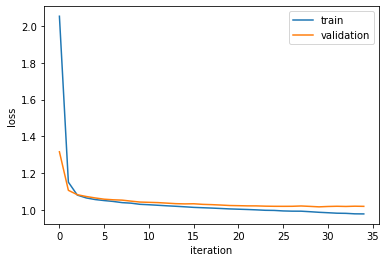

In [31]:
# plot training history
plt.plot(autorec_opt.hist.history['loss'], label='train')
plt.plot(autorec_opt.hist.history['val_loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()

In [32]:
autorec_opt.model = load_model('best_autorec_model.h5', custom_objects={'masked_rmse': IAutoRec.masked_rmse})


In [33]:
shutil.rmtree('/content/hyper_params')

### Prediction

In [34]:
# autorec.predict(np.zeros(test_mat.shape))
autorec_opt.predict(test_mat)

12/12 [==============================] - 0s 3ms/step


### Evaluation

In [35]:
autorec_opt_eval = Metrics.get_evaluation(test_mat, autorec_opt.predictions)
autorec_opt_eval

{'MRR_10': 0.9714761345196127,
 'MRR_5': 0.9714761345196127,
 'NDCG_10': 0.9595427502854806,
 'NDCG_100': 0.9632571344257689,
 'NDCG_5': 0.9654666019128131,
 'RMSE': 1.2223770940373277}

Text(0, 0.5, 'values')

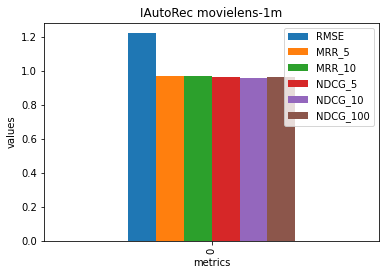

In [36]:
autorec_opt_eval_df = pd.DataFrame(autorec_opt_eval, index=[0])
autorec_opt_eval_df.plot(kind='bar')
plt.title('IAutoRec movielens-1m')
plt.xlabel('metrics')
plt.ylabel('values')

Note that we did not acheive similar results as the paper. our model's RMSE reaches 1.2 while the paper's reches 0.831. <br> This is quite a big difference, the reasons colud be explained by getting different hyperparameters. 
The paper does not disclose all of the hyperparameters.
It describes some of them, such as regularization, hidden layer size and activation functions. Other parameters such as learning rate are not available, furthermore they use a different train and evaluation mechanism: "We repeat this splitting procedure 5 times and report average RMSE."

## IAutoRec Enhanced

the suggested enhanced model is build with more layers:

1.   input layer (like the base model)
2.   hidden encoder layer
3.   dense layer (like the base model)
4.   hidden dencoder layer
5.   output layer (like the base model)



### HyperParameters Tuning

hyperparameters:


*   hidden units = {100, 200, 300}
*   hidden units factor = {2, 3}
*   regularization = {0.001, 0.0001}
*   learning rate = {1e-3, 1e-4}
*   in activation function = {RELU, Sigmoid, ELU}
*   out activation function = {RELU, Sigmoid, ELU}


In [37]:
autorec_enhanced = IAutoRecEnhanced(train_mat.shape[1])
tuner = kt.Hyperband(autorec_enhanced.model_builder,
                     objective='val_loss',
                    #  objective='loss',
                     max_epochs=500,
                    #  factor=3,
                     directory='hyper_params',
                     project_name='autorec_enhanced_ml')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 item_rating (InputLayer)    [(None, 3706)]            0         
                                                                 
 hidden_encoder_1 (Dense)    (None, 200)               741400    
                                                                 
 latent_dim (Dense)          (None, 100)               20100     
                                                                 
 hidden_decoder_1 (Dense)    (None, 200)               20200     
                                                                 
 item_pred_rating (Dense)    (None, 3706)              744906    
                                                                 
Total params: 1,526,606
Trainable params: 1,526,606
Non-trainable params: 0
_________________________________________________________________


In [38]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
tuner.search(train_mat, train_mat,
             epochs=500, validation_split=0.1, callbacks=[stop_early], batch_size=512)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 168 Complete [00h 00m 02s]
val_loss: 1.5840271711349487

Best val_loss So Far: 1.109140157699585
Total elapsed time: 00h 05m 15s
INFO:tensorflow:Oracle triggered exit


In [39]:
best_hps.get('hidden_units'), best_hps.get('hidden_layer_factor'), best_hps.get('first_activation'), best_hps.get('last_activation'), best_hps.get('reg'), best_hps.get('learning_rate')

(100, 3, 'sigmoid', 'elu', 0.0001, 0.001)

### Retraining

In [40]:
autorec_enhanced_opt = IAutoRecEnhanced(train_mat.shape[1],hidden_units=best_hps.get('hidden_units'), 
                                        hidden_layer_factor=best_hps.get('hidden_layer_factor'), reg=best_hps.get('reg'), 
                                        learning_rate=best_hps.get('learning_rate'), first_activation=best_hps.get('first_activation'),
                                        last_activation=best_hps.get('last_activation'))
autorec_enhanced_opt.build_opt_model()
autorec_enhanced_opt.fit(train_mat, train_mat)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 item_rating (InputLayer)    [(None, 3706)]            0         
                                                                 
 hidden_encoder (Dense)      (None, 300)               1112100   
                                                                 
 latent_dim (Dense)          (None, 100)               30100     
                                                                 
 hidden_decoder (Dense)      (None, 300)               30300     
                                                                 
 item_pred_rating (Dense)    (None, 3706)              1115506   
                                                                 
Total params: 2,288,006
Trainable params: 2,288,006
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
22/22 - 1s - loss: 2.2239 - val_loss:

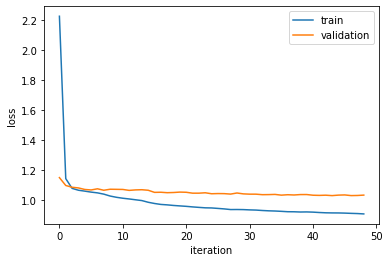

In [41]:
# plot training history
plt.plot(autorec_enhanced_opt.hist.history['loss'], label='train')
plt.plot(autorec_enhanced_opt.hist.history['val_loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()

In [42]:
autorec_enhanced_opt.model = load_model('best_autorec_enhanced_model.h5', custom_objects={'masked_rmse': IAutoRecEnhanced.masked_rmse})

In [43]:
shutil.rmtree('/content/hyper_params')

### Prediction

In [45]:
autorec_enhanced_opt.predict(test_mat)

12/12 [==============================] - 0s 3ms/step


### Evaluation

In [46]:
autorec_enhanced_opt_eval = Metrics.get_evaluation(test_mat, autorec_enhanced_opt.predictions)
autorec_enhanced_opt_eval

{'MRR_10': 0.97040456605674,
 'MRR_5': 0.97040456605674,
 'NDCG_10': 0.9592570543224679,
 'NDCG_100': 0.9632617725974328,
 'NDCG_5': 0.9651301862514317,
 'RMSE': 1.0166728553257713}

Text(0, 0.5, 'values')

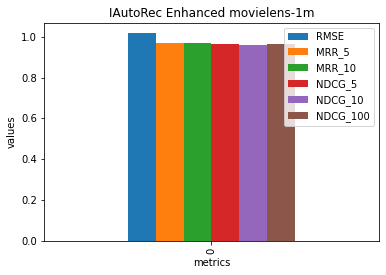

In [47]:
autorec_enhanced_opt_eval_df = pd.DataFrame(autorec_enhanced_opt_eval, index=[0])
autorec_enhanced_opt_eval_df.plot(kind='bar')
plt.title('IAutoRec Enhanced movielens-1m')
plt.xlabel('metrics')
plt.ylabel('values')

we managed to get better results, but still, not as good as the paper suggests, we'll try next a deeper architecture.

## IAutoRec Enhanced 2

the suggested enhanced 2 model is build with more layers:

1.   input layer (like the base model)
2.   hidden encoder layer 1
3.   hidden encoder layer 2
4.   dense layer (like the base model)
5.   hidden dencoder layer 1
6.   hidden dencoder layer 2
7.   output layer (like the base model)

### HyperParameters Tuning

hyperparameters:


*   hidden units = {50, 100}
*   hidden units factor = {2}
*   regularization = {0.001, 0.0001}
*   learning rate = {1e-3, 1e-4}
*   in activation function = {RELU, Sigmoid, ELU}
*   out activation function = {RELU, Sigmoid, ELU}

In [48]:
autorec_enhanced2 = IAutoRecEnhanced2(train_mat.shape[1])
tuner = kt.Hyperband(autorec_enhanced2.model_builder,
                     objective='val_loss',
                    #  objective='loss',
                     max_epochs=500,
                    #  factor=3,
                     directory='hyper_params',
                     project_name='autorec_enhanced2_ml')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 item_rating (InputLayer)    [(None, 3706)]            0         
                                                                 
 hidden_encoder_1 (Dense)    (None, 200)               741400    
                                                                 
 hidden_encoder_2 (Dense)    (None, 100)               20100     
                                                                 
 latent_dim (Dense)          (None, 50)                5050      
                                                                 
 hidden_decoder_1 (Dense)    (None, 100)               5100      
                                                                 
 hidden_decoder_2 (Dense)    (None, 200)               20200     
                                                                 
 item_pred_rating (Dense)    (None, 3706)              7449

In [49]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
tuner.search(train_mat, train_mat,
             epochs=500, validation_split=0.1, callbacks=[stop_early], batch_size=512)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 127 Complete [00h 00m 01s]
val_loss: 2.932190179824829

Best val_loss So Far: 1.1171069145202637
Total elapsed time: 00h 04m 15s
INFO:tensorflow:Oracle triggered exit


In [50]:
best_hps.get('hidden_units'), best_hps.get('hidden_layer_factor'), best_hps.get('first_activation'), best_hps.get('last_activation'), best_hps.get('reg'), best_hps.get('learning_rate')

(50, 2, 'elu', 'elu', 0.0001, 0.001)

### Retraining

In [15]:
# autorec_enhanced2_opt = IAutoRecEnhanced2(train_mat.shape[1],hidden_units=best_hps.get('hidden_units'), 
#                                         hidden_layer_factor=best_hps.get('hidden_layer_factor'), reg=best_hps.get('reg'), 
#                                         learning_rate=best_hps.get('learning_rate'), first_activation=best_hps.get('first_activation'),
#                                         last_activation=best_hps.get('last_activation'))
autorec_enhanced2_opt.build_opt_model()
autorec_enhanced2_opt.fit(train_mat, train_mat)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 item_rating (InputLayer)    [(None, 3706)]            0         
                                                                 
 hidden_encoder_1 (Dense)    (None, 200)               741400    
                                                                 
 hidden_encoder_2 (Dense)    (None, 100)               20100     
                                                                 
 latent_dim (Dense)          (None, 50)                5050      
                                                                 
 hidden_decoder_1 (Dense)    (None, 100)               5100      
                                                                 
 hidden_decoder_2 (Dense)    (None, 200)               20200     
                                                                 
 item_pred_rating (Dense)    (None, 3706)              744906

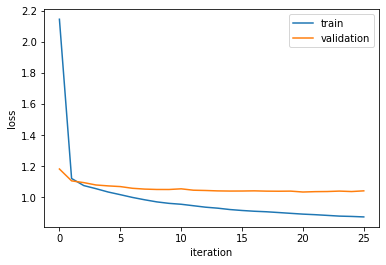

In [16]:
# plot training history
plt.plot(autorec_enhanced2_opt.hist.history['loss'], label='train')
plt.plot(autorec_enhanced2_opt.hist.history['val_loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()

In [17]:
autorec_enhanced2_opt.model = load_model('best_autorec_enhanced2_model.h5', custom_objects={'masked_rmse': IAutoRecEnhanced2.masked_rmse})

In [18]:
shutil.rmtree('/content/hyper_params')

### Prediction

In [19]:
autorec_enhanced2_opt.predict(test_mat)

12/12 [==============================] - 0s 4ms/step


### Evaluation

In [20]:
autorec_enhanced2_opt_eval = Metrics.get_evaluation(test_mat, autorec_enhanced2_opt.predictions)
autorec_enhanced2_opt_eval

{'MRR_10': 0.9736864193385932,
 'MRR_5': 0.9736304627608975,
 'NDCG_10': 0.9600791532658715,
 'NDCG_100': 0.9623368835199153,
 'NDCG_5': 0.9667704623745941,
 'RMSE': 1.1964673199969456}

Text(0, 0.5, 'values')

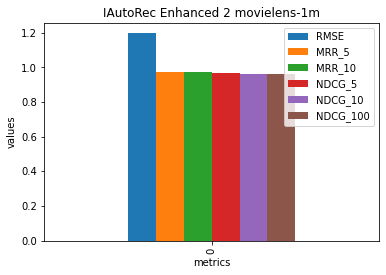

In [21]:
autorec_enhanced2_opt_eval_df = pd.DataFrame(autorec_enhanced2_opt_eval, index=[0])
autorec_enhanced2_opt_eval_df.plot(kind='bar')
plt.title('IAutoRec Enhanced 2 movielens-1m')
plt.xlabel('metrics')
plt.ylabel('values')

we got worse results than the simpler model, this might be due to a needed heavy duty hyperparameter tuninng.

## Models Metrics Comparison

In [25]:
result_dict = {
    'mf': mf_opt_eval,
    'autorec': autorec_opt_eval,
    'autorec_enhanced': autorec_enhanced_opt_eval,
    'autorec_enhanced2': autorec_enhanced2_opt_eval
               }
res_df = pd.DataFrame.from_dict(result_dict)
res_df

,mf,autorec,autorec_enhanced,autorec_enhanced2
MRR_10,0.977408,0.971476,0.970405,0.973686
MRR_5,0.977408,0.971476,0.970405,0.973630
NDCG_10,0.967013,0.959543,0.959257,0.960079
NDCG_100,0.972053,0.963257,0.963262,0.962337
NDCG_5,0.971676,0.965467,0.965130,0.966770
RMSE,0.858593,1.222377,1.016673,1.196467


Text(0.5, 1.0, 'movielens-1m models results')

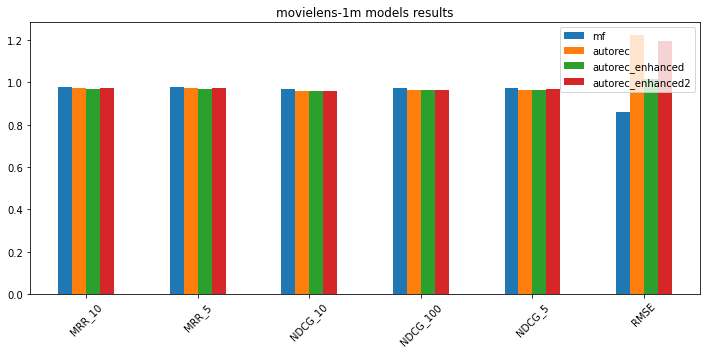

In [26]:
res_df.plot(kind='bar', figsize=(12,5), rot=45)
plt.title('movielens-1m models results')

Text(0.5, 1.0, 'movielens-1m models results')

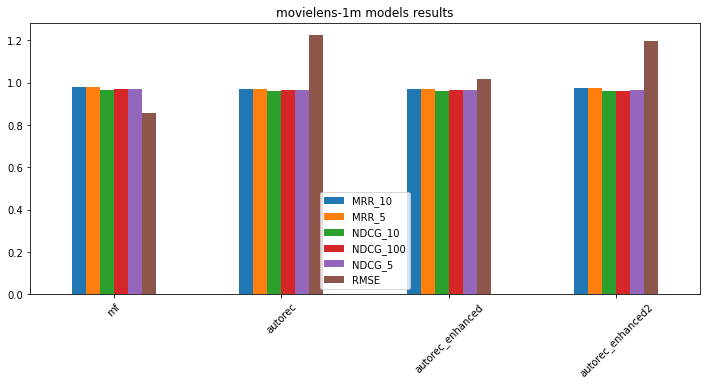

In [27]:
res_df.transpose().plot(kind='bar', figsize=(12,5), rot=45)
plt.title('movielens-1m models results')